# Cyber Threat Analyzer (CTA) - Part 1: Finding the Signal in the Noise

**Goal:** Ingest raw system log data, parse it into a structured format using Pandas and Regex, enrich it with threat intelligence from the AbuseIPDB API, and prepare it for exploratory data analysis (EDA).

### The "Why"
Raw log files are 99% routine system chatter or what we'll call "audio static". Hidden inside that noise is the 1% that truly matters: the "signal." This signal is our actionable intelligence - the failed logins, the weird connections, the real threats. The purpose of this notebook is to build the automatic noise filter. We'll use data engineering to turn that "wall of noise" into a clean, actionable signal, building the foundation for our ML model.

In [15]:
# This is the core library for building
# our data table (DataFrame).
import pandas as pd

# Pathlib makes it easy to build paths that work
# on multiple operating systems.
from pathlib import Path

# The Regular Expression library. This "pattern-matcher"
# will extract actionable data from the noise.
import re

print("Import Complete")

Import Complete


## Step 1: Parse Raw Log File

### The "Why"
We know that log files are 99% "audio static". This is where we start building the "noise filter" to isolate the "signal".

### The "How"
Our goal is to use a **Regular Expression (regex)** to tell Python exactly how to read each line and find three specific pieces:

1.  The `TIMESTAMP`
2.  The `[LOG_LEVEL]`
3.  The `MESSAGE`

We'll extract these pieces, put them into a list, and then load that list into a clean, structured Pandas DataFrame.

In [16]:
# This regex is our new "noise filter" for the syslog format.
#
#    ^         # Start of the line
#    (.{15})   # Capture Group 1: The first 15 chars (the timestamp 'Oct 10 00:01:01')
#    \s+       # Match one or more spaces
#    ([\w\d\.-]+) # Capture Group 2: The hostname (e.g., 'server-01')
#    \s+       # Match one or more spaces
#    ([^:]+):  # Capture Group 3: The process/PID (e.g., 'CRON[1001]')
#    \s+       # Match one or more spaces
#    (.*)      # Capture Group 4: "Capture everything else" (the message)
#    $         # End of the line
#
log_pattern = re.compile(r'^(.{15})\s+([\w\d\.-]+)\s+([^:]+):\s+(.*)$')

# Use 'pathlib' to build a smart file path that works on any OS.
log_file_path = Path.cwd().parent / "data" / "system.log"

# Create empty list to store structured data
data = []

# Now, let's open the log file and read it one line at a time.
try:
    with open(log_file_path, 'r') as f:
        for line in f:
            # Try to match regex "formula" to the current line
            match = log_pattern.match(line)
            
            # If the line matched our pattern, extract the captured groups
            if match:
                data.append({
                    'timestamp': match.group(1),
                    'hostname': match.group(2),
                    'process': match.group(3).strip(),
                    'message': match.group(4).strip()   # .strip() cleans up hidden whitespace
                })
            # Optional: Log a message if a line doesn't match
            # else:
            #    print(f"No match for line: {line.strip()}")

    # Define the columns in the order we want them
    columns = ['timestamp', 'hostname', 'process', 'message']

    # Create Pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(data, columns=columns)

    print(f"--- CTA Parser finished. Found {len(data)} log entries. ---")

except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"Could not find the log file at this path: {log_file_path}")
    print("Please double-check the 'log_file_path' variable in this cell.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- CTA Parser finished. Found 76 log entries. ---


### Verify Initial Parsing

Let's display the first few rows using `df.head()` to ensure the regex worked correctly and we have our initial `timestamp`, `log_level`, and `message` columns.

In [17]:
# Display the first 5 rows to make sure it worked
df.head()

,timestamp,hostname,process,message
0,Oct 10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily)
1,Oct 10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345
2,Oct 10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345
3,Oct 10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...
4,Oct 10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1


### Step 1.1: Extract "Log Level" Feature

Our new parser grabs the whole message. We now need to "tune in" to that message and extract the `log_level` (like `[ERROR]`, `[WARNING]`) as its own feature. We will write a function for this and, just like with our IP extractor, use `.apply()` to create a new `log_level` column.

We will default any log without a specific level to `INFO`, as that represents our baseline "static."

In [18]:
def extract_log_level(message):
    """
    Uses regex to find a log level like [ERROR] or [WARNING]
    in a message string. Defaults to 'INFO' if none is found.
    """
    # Regex pattern to find a word inside square brackets
    level_pattern = r'\[(\w+)\]'
    
    match = re.search(level_pattern, message)
    
    if match:
        # Return the captured word (e.g., 'ERROR')
        return match.group(1) 
    else:
        # Default to 'INFO' for all other "static"
        return 'INFO'

# Create the new 'log_level' column
df['log_level'] = df['message'].apply(extract_log_level)

print("Created 'log_level' column.")

# Display the DataFrame to see the new column
df.head()

Created 'log_level' column.


,timestamp,hostname,process,message,log_level
0,Oct 10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily),INFO
1,Oct 10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO
2,Oct 10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO
3,Oct 10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...,INFO
4,Oct 10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1,INFO


## Step 2: Load API Key Securely

We need our AbuseIPDB API key to enrich the data. We load it securely from a `.env` file using the `python-dotenv` library. This is a critical security step that ensures our secret key is never accidentally "committed" and leaked on GitHub, where bots are constantly scanning for credentials.

In [19]:
import os
from dotenv import load_dotenv # Import the new library

# This line automatically finds the .env file in root
# and loads the variables found inside into the environment
# of this specific notebook session.
load_dotenv()

# This should now find the key
api_key = os.environ.get('ABUSEIPDB_KEY')

if api_key:
    print("Success! API Key loaded successfully from .env file.")
    # Optional: Verify the key looks right
    # print(f"   Key starts with: {api_key[:5]}... and ends with: {api_key[-5:]}")
else:
    print("Error: API Key not found.")
    print("   1. Did you create the `.env` file in the 'cta' root folder?")
    print("   2. Does the `.env` file contain 'ABUSEIPDB_KEY=your-key'?")
    print("   3. Did you install 'python-dotenv' (`pip install python-dotenv`)?")
    print("   4. Did you run the `load_dotenv()` command in this cell?")

Success! API Key loaded successfully from .env file.


## Step 3: Build the Threat Intel Function

This is a key part of our noise filter. We will build the check_ip function to be our automated intel analyst. Its job is to call the AbuseIPDB API and find if the IP is a known threat.

We will then unit test it with a sample malicious IP (1.2.3.4) to make sure our new tool works before we use it on all our data.

In [20]:
# Import the libraries needed *for this cell*
import requests
import json # For formatting the JSON output

# --- 1. Load the API Key (using dotenv) ---
# We are now relying on the 'api_key' variable
# that we loaded in the previous cell.

# --- 2. Define the Function to Check an IP ---
def check_ip(ip_address, key):
    """
    Calls the AbuseIPDB API to check a given IP address.
    Returns the JSON response from the API.
    """
    if not key:
        print("API Key not loaded. Cannot check IP.")
        return None # Return nothing if the key isn't loaded

    # Define the API endpoint and parameters
    url = 'https://api.abuseipdb.com/api/v2/check'
    params = {
        'ipAddress': ip_address,
        'maxAgeInDays': '90', # How far back to look for reports
        'verbose': True # Ask for more details if available
    }
    headers = {
        'Accept': 'application/json',
        'Key': key
    }

    print(f"Checking IP: {ip_address}...")
    try:
        response = requests.get(url=url, headers=headers, params=params)
        response.raise_for_status() # Raise an error for bad status codes (4xx or 5xx)

        # If successful, parse the JSON response
        report = response.json()
        return report['data'] # Return just the 'data' part of the response

    except requests.exceptions.RequestException as e:
        print(f"  Error during API request: {e}")
        return None
    except Exception as e:
        print(f"  An unexpected error occurred: {e}")
        return None

# --- 3. Test the function with a known bad IP ---
test_ip = '1.2.3.4' # A commonly reported IP for testing

# Check if 'api_key' exists in memory from the previous cell
if 'api_key' in locals() and api_key:
    ip_data = check_ip(test_ip, api_key)

    # --- 4. Print the results nicely ---
    if ip_data:
        print("\n--- API Report Received ---")
        print(f"  IP Address: {ip_data.get('ipAddress')}")
        print(f"  Country: {ip_data.get('countryCode')}")
        print(f"  Abuse Score: {ip_data.get('abuseConfidenceScore')}%")
        print(f"  Total Reports: {ip_data.get('totalReports')}")
        print(f"  ISP: {ip_data.get('isp')}")
        # print("\nFull Report:") # Uncomment to see everything
        # print(json.dumps(ip_data, indent=2))
    else:
        print("\n--- Failed to get API report ---")
else:
    print("API Key not loaded, skipping test. (Did you run the previous cell?)")

Checking IP: 1.2.3.4...

--- API Report Received ---
  IP Address: 1.2.3.4
  Country: AU
  Abuse Score: 50%
  Total Reports: 42
  ISP: APNIC Debogon Project


## Step 4: Extract the "Signal" (IPs) from the "Static"

This is the heart of our 'noise filter'. We need to find the "signal" (the IP addresses) hidden inside the "static" (the log messages). To do this, we'll build a function.

In [21]:
def extract_ip(message):
    """
    Uses regex to find the first IPv4 address in a string.
    Returns the IP address string if found, otherwise None.
    """
    # Regex pattern for an IPv4 address
    # \b matches word boundaries to avoid partial matches
    # (?:\d{1,3}\.){3} matches three groups of (1-3 digits followed by a dot)
    # \d{1,3} matches the final 1-3 digits
    ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'

    match = re.search(ip_pattern, message) # Find the first match in the message

    if match:
        return match.group(0) # Return the matched IP string
    else:
        return None # Return None if no IP was found

In [22]:
# Test cases
test_message_with_ip = "Failed login for user 'root' from IP 1.2.3.4"
test_message_no_ip = "System startup complete."

# Run the function
found_ip = extract_ip(test_message_with_ip)
no_ip = extract_ip(test_message_no_ip)

print(f"IP found in first message: {found_ip}")
print(f"IP found in second message: {no_ip}")

IP found in first message: 1.2.3.4
IP found in second message: None


### Apply IP Extraction to DataFrame

Now, we use the Pandas `.apply()` method to run our `extract_ip` function on every row in the `message` column, creating a new `ip_address` column in our DataFrame.

In [23]:
# Create the new 'ip_address' column
# The 'lambda x:' part passes each message ('x') into our function.
df['ip_address'] = df['message'].apply(lambda x: extract_ip(x))

print("Created 'ip_address' column.")

# Display the DataFrame to see the new column!
df.head(10) # Show more rows to potentially see IPs and None values

Created 'ip_address' column.


,timestamp,hostname,process,message,log_level,ip_address
0,Oct 10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily),INFO,None
1,Oct 10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4
2,Oct 10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4
3,Oct 10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...,INFO,103.207.39.18
4,Oct 10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1,INFO,1.1.1.1
5,Oct 10 02:14:15,server-01,sshd[1201],Accepted password for user researcher from 192...,INFO,192.168.1.10
6,Oct 10 02:30:11,server-01,sshd[1230],Failed password for invalid user guest from 22...,INFO,222.186.17.182
7,Oct 10 02:30:15,server-01,sshd[1230],Failed password for invalid user guest from 22...,INFO,222.186.17.182
8,Oct 10 03:01:09,server-01,kernel,"[2101.001] usb 1-1: New USB device found, idVe...",INFO,None
9,Oct 10 03:05:11,server-01,CRON[2250],(root) CMD (run-parts /etc/cron.hourly),INFO,None


## Step 5: Create the "IP Watchlist"

Our 'automated intel analyst' is ready, but we need to be smart. If we have 10,000 logs but only 3 unique IPs, we don't want to make 10,000 API calls. That's a great way to get rate-limited.

In [24]:
# Get all unique values from the 'ip_address' column
unique_ips = df['ip_address'].unique()

# Filter out any 'None' values (which pandas often represents as float 'nan')
# We only want actual IP strings
ips_to_check = [ip for ip in unique_ips if isinstance(ip, str)]

# How many unique IPs do we actually need to check?
print(f"Found {len(ips_to_check)} unique IP addresses to check.")
print("Unique IPs:", ips_to_check)

Found 13 unique IP addresses to check.
Unique IPs: ['1.2.3.4', '103.207.39.18', '1.1.1.1', '192.168.1.10', '222.186.17.182', '185.191.205.10', '104.248.153.212', '192.168.1.50', '8.8.8.8', '10.0.5.10', '45.9.148.190', '10.0.5.100', '198.55.103.22']


### Build the "Threat Intel Cache"

We loop only through the unique IPs, call our check_ip function for each, and store the results (abuse score, country) in a dictionary (ip_report_cache). This acts as a temporary lookup table to minimize API calls.

In [25]:
# We are relying on the 'api_key' and 'ips_to_check' variables
# that we created in the previous cells.

# Dictionary to store the results: {ip: {'score': score, 'country': country}, ...}
ip_report_cache = {}

if 'api_key' in locals() and api_key:
    print("--- Starting API checks for unique IPs ---")
    
    # Loop through only the unique IPs found
    for ip in ips_to_check:
        print(f"Checking {ip}...")
        report_data = check_ip(ip, api_key) # Call the function we wrote earlier

        if report_data:
            # Store the relevant info (score and country) in our cache
            ip_report_cache[ip] = {
                'score': report_data.get('abuseConfidenceScore'),
                'country': report_data.get('countryCode')
                # Add any other fields you want here! e.g., 'isp': report_data.get('isp')
            }
        else:
            # Handle cases where the API might fail for a specific IP
            ip_report_cache[ip] = {'score': None, 'country': None}
            print(f"   -> Failed to get report for {ip}")

    print("--- Finished API checks ---")
    print("\nIP Report Cache:")
    print(ip_report_cache)

else:
    print("API Key not found. Cannot perform checks. (Did you run Step 2?)")

--- Starting API checks for unique IPs ---
Checking 1.2.3.4...
Checking IP: 1.2.3.4...
Checking 103.207.39.18...
Checking IP: 103.207.39.18...
Checking 1.1.1.1...
Checking IP: 1.1.1.1...
Checking 192.168.1.10...
Checking IP: 192.168.1.10...
Checking 222.186.17.182...
Checking IP: 222.186.17.182...
Checking 185.191.205.10...
Checking IP: 185.191.205.10...
Checking 104.248.153.212...
Checking IP: 104.248.153.212...
Checking 192.168.1.50...
Checking IP: 192.168.1.50...
Checking 8.8.8.8...
Checking IP: 8.8.8.8...
Checking 10.0.5.10...
Checking IP: 10.0.5.10...
Checking 45.9.148.190...
Checking IP: 45.9.148.190...
Checking 10.0.5.100...
Checking IP: 10.0.5.100...
Checking 198.55.103.22...
Checking IP: 198.55.103.22...
--- Finished API checks ---

IP Report Cache:
{'1.2.3.4': {'score': 50, 'country': 'AU'}, '103.207.39.18': {'score': 0, 'country': 'VN'}, '1.1.1.1': {'score': 0, 'country': 'AU'}, '192.168.1.10': {'score': 0, 'country': None}, '222.186.17.182': {'score': 0, 'country': 'CN'}, '

### Merge "Threat Intel" Back into the DataFrame

Now we'll merge our threat intel from the ip_report_cacheback to our main log data. We'll use the.map()function to look up *every* IP address against our cache and create the newabuse_scoreandcountry columns. This is the final step in enriching our "signal".

In [26]:
# Using the .map() method
# For each IP in 'ip_address', it looks up that IP in our cache
# and then retrieves the 'score' value from the nested dictionary.
df['abuse_score'] = df['ip_address'].map(lambda ip: ip_report_cache.get(ip, {}).get('score'))

# Do the same for the country code
df['country'] = df['ip_address'].map(lambda ip: ip_report_cache.get(ip, {}).get('country'))

print("Added 'abuse_score' and 'country' columns to the DataFrame.")

# Let's see the final enriched DataFrame
df.head(10)

Added 'abuse_score' and 'country' columns to the DataFrame.


,timestamp,hostname,process,message,log_level,ip_address,abuse_score,country
0,Oct 10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily),INFO,None,NaN,None
1,Oct 10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU
2,Oct 10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU
3,Oct 10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...,INFO,103.207.39.18,0.0,VN
4,Oct 10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1,INFO,1.1.1.1,0.0,AU
5,Oct 10 02:14:15,server-01,sshd[1201],Accepted password for user researcher from 192...,INFO,192.168.1.10,0.0,None
6,Oct 10 02:30:11,server-01,sshd[1230],Failed password for invalid user guest from 22...,INFO,222.186.17.182,0.0,CN
7,Oct 10 02:30:15,server-01,sshd[1230],Failed password for invalid user guest from 22...,INFO,222.186.17.182,0.0,CN
8,Oct 10 03:01:09,server-01,kernel,"[2101.001] usb 1-1: New USB device found, idVe...",INFO,None,NaN,None
9,Oct 10 03:05:11,server-01,CRON[2250],(root) CMD (run-parts /etc/cron.hourly),INFO,None,NaN,None


## Step 6: Clean Timestamp Data

The `timestamp` column is currently text (`object`). We convert it to a proper `datetime` object using `pd.to_datetime()` so Pandas understands it as time data. We verify the conversion using `df.info()`.

In [27]:
# Create a clean datetime column
#
# We add the 'format=' argument to tell Pandas exactly
# what our timestamp looks like.
#
# %b = Month abbreviation (e.g., 'Oct')
# %d = Day of the month (e.g., '10')
# %H = Hour (24-hour)
# %M = Minute
# %S = Second
#
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%b %d %H:%M:%S")
    print("Cleaned 'timestamp' column (with format).")
    
    # Since our log format has NO YEAR, Pandas defaults to 1900.
    # Let's write a fix to assume the current year.
    current_year = pd.Timestamp.now().year
    df['timestamp'] = df['timestamp'].apply(lambda x: x.replace(year=current_year))
    print(f"Updated all timestamps to assume the current year ({current_year}).")

except Exception as e:
    print(f"Error converting timestamp: {e}")
    print("Check the 'format' string in this cell against the log file's timestamp.")

# Display the DataFrame to see the updated column
df.head()

Cleaned 'timestamp' column (with format).
Updated all timestamps to assume the current year (2025).


,timestamp,hostname,process,message,log_level,ip_address,abuse_score,country
0,2025-10-10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily),INFO,None,NaN,None
1,2025-10-10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU
2,2025-10-10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU
3,2025-10-10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...,INFO,103.207.39.18,0.0,VN
4,2025-10-10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1,INFO,1.1.1.1,0.0,AU


### Extract Hour of Day Feature

Now that `timestamp` is a datetime object, we can easily extract time components. We use the `.dt.hour` accessor to create a new `hour_of_day` column and display `df.head()` again to see the result.

In [28]:
# Create a new column 'hour_of_day' by extracting the hour (0-23)
# The '.dt' accessor only works on datetime columns
df['hour_of_day'] = df['timestamp'].dt.hour

print("Added 'hour_of_day' column.")

# Let's see the DataFrame with the new hour column
df.head()

Added 'hour_of_day' column.


,timestamp,hostname,process,message,log_level,ip_address,abuse_score,country,hour_of_day
0,2025-10-10 00:01:01,server-01,CRON[1001],(root) CMD (run-parts /etc/cron.daily),INFO,None,NaN,None,0
1,2025-10-10 00:15:22,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU,0
2,2025-10-10 00:15:26,server-01,sshd[1020],Failed password for root from 1.2.3.4 port 12345,INFO,1.2.3.4,50.0,AU,0
3,2025-10-10 01:10:15,server-01,sshd[1101],Received disconnect from 103.207.39.18: 11: By...,INFO,103.207.39.18,0.0,VN,1
4,2025-10-10 01:30:05,server-01,webapp[505],[INFO] API query for /api/v1/status from 1.1.1.1,INFO,1.1.1.1,0.0,AU,1


## Phase 2: Tuning In to the "Signal" (EDA)

We have successfully filtered the "static" and enriched our data. Our `df` DataFrame now contains the clean "signal".

The goal of this phase is to perform Exploratory Data Analysis (EDA). Before we can automate threat detection, we must first understand the signal ourselves. We will use visualizations to build a "Signal Report" that answers key questions:

1.  What is the overall tone of the logs? (e.g., mostly routine info, or full of errors?)
2.  When does the signal arrive? (e.g., are there spikes at certain hours?)
3.  Where is the signal coming from? (e.g., specific countries or high-risk IPs?)

### Step 2.1: Import Visualization Toolbox

First, we need to import our new display tools, `matplotlib` and `seaborn`. We'll also set a default theme to make our charts look clean and professional.

In [29]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional theme for our charts
sns.set_theme(style="darkgrid")

print("Visualization libraries imported and theme set.")

Visualization libraries imported and theme set.


### Step 2.2: Chart 1 - The "Log Level" Breakdown

Our first chart acts as a simple volume meter. It answers the question: "What is the overall tone of our logs?"

We will use a **countplot** to see the distribution of `log_level` categories. This gives us an immediate baseline. If 99% of logs are `INFO`, that is our normal static. A spike in `ERROR` or `WARNING` would be the first hint of a problem.

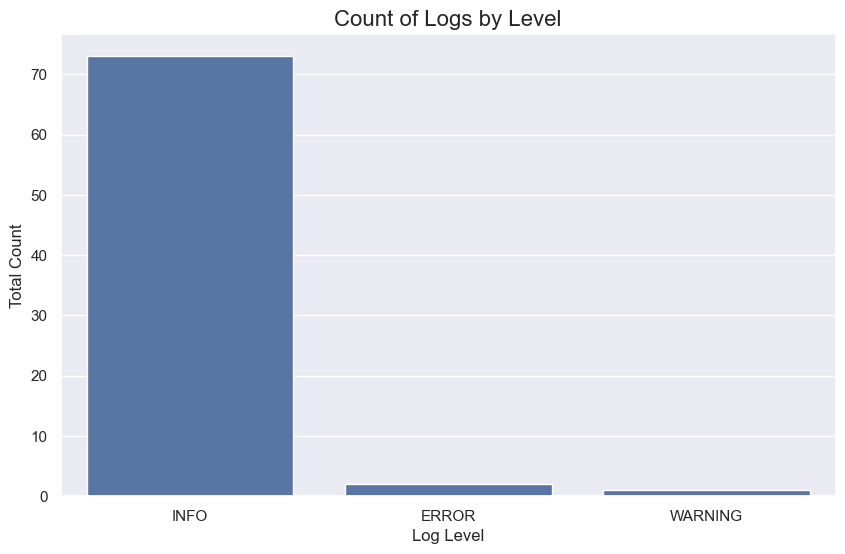

In [30]:
# Create a figure and set its size for better readability
plt.figure(figsize=(10, 6))

# Create the countplot
# We set 'order' to sort the bars from most frequent to least frequent
chart = sns.countplot(
    data=df,
    x='log_level',
    order=df['log_level'].value_counts().index
)

# Add clear titles and labels
chart.set_title('Count of Logs by Level', fontsize=16)
chart.set_xlabel('Log Level', fontsize=12)
chart.set_ylabel('Total Count', fontsize=12)

# Save the figure to a file
# This is for sharing our "Signal Report"
plt.savefig('01-log_level_distribution.png')

# Display the chart in the notebook
plt.show()

### Step 2.3: Chart 2 - Signal Timing (Logs by Hour)

Now we will investigate when the signals are arriving. This chart plots the total number of log entries for each hour of the day (0-23).

Think of this chart as a 24-hour audio equalizer (EQ). If the levels are all flat, it is just static (consistent activity). But if we see sharp spikes or dips, that is our waveform—a signal breaking through the noise. A huge spike at 3:00 AM, for instance, is a loud signal that strongly suggests automated attacks.

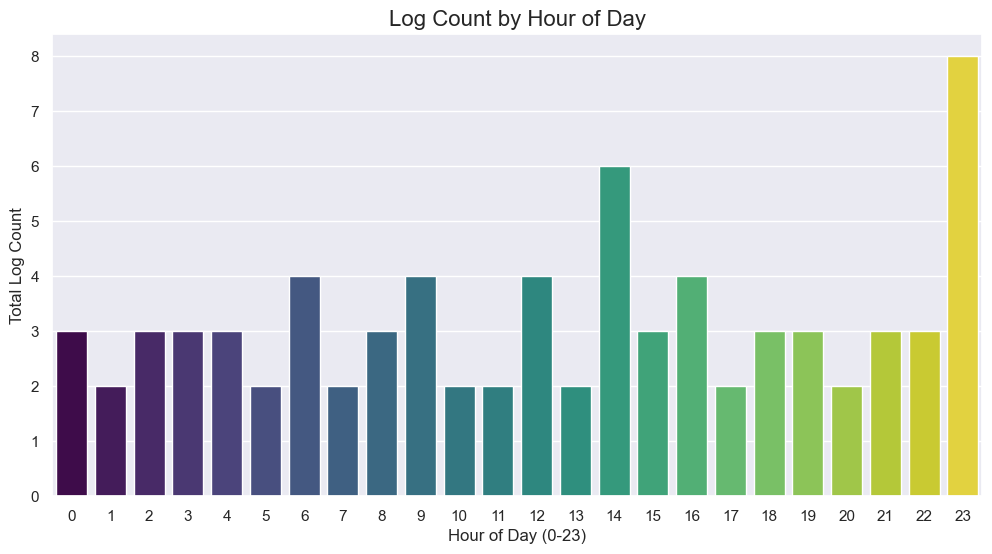

In [31]:
# Create a figure and set its size
plt.figure(figsize=(12, 6))

# Create the countplot for 'hour_of_day'
chart = sns.countplot(
    data=df,
    x='hour_of_day',
    # Explicitly map 'hour_of_day' to hue (color)
    hue='hour_of_day', 
    # Use our chosen color palette
    palette='viridis',
    # Turn off the legend, which is redundant for this chart
    legend=False 
)

# Add clear titles and labels
chart.set_title('Log Count by Hour of Day', fontsize=16)
chart.set_xlabel('Hour of Day (0-23)', fontsize=12)
chart.set_ylabel('Total Log Count', fontsize=12)

# Save the figure
plt.savefig('02-log_count_by_hour.png')

# Display the chart
plt.show()

### Step 2.4: Chart 3 - Threat Score Analysis (Abuse Score)

We have looked at our internal logs. Now it is time to look at the external threat intelligence we gathered. This chart answers: "Are the IPs in our logs harmless, or are they known threats?"

We will use a histogram for this. It groups the numeric `abuse_score` (0-100) into "bins" and counts how many IPs fall into each one.

This gives us an immediate "Threat Profile." We can see if our signal is mostly "noise" (IPs with a score of 0) or if it contains a clear "threat" (a spike of IPs with scores of 75+).

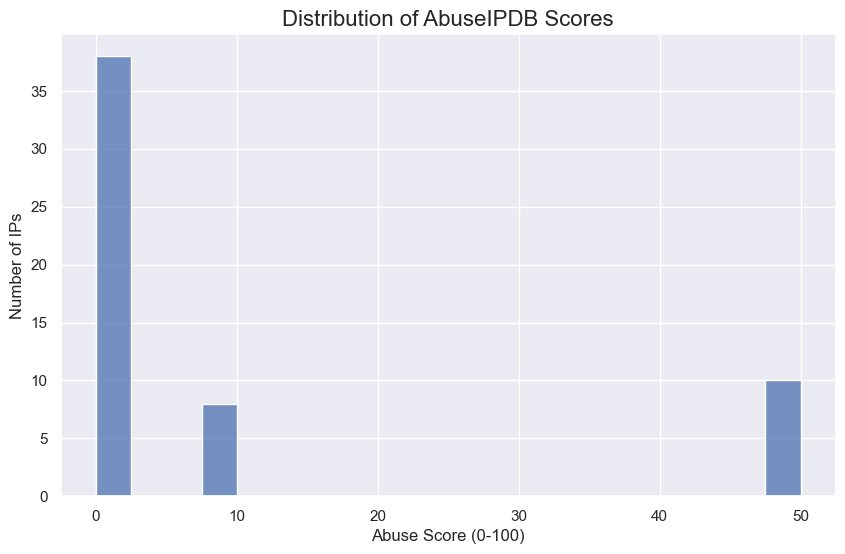

In [32]:
# Create a figure and set its size
plt.figure(figsize=(10, 6))

# Create the histogram
# We must .dropna() for this column, as we only want
# to plot the IPs that actually had a score.
chart = sns.histplot(
    data=df.dropna(subset=['abuse_score']), 
    x='abuse_score',
    bins=20,  # Group the 0-100 scores into 20 bars
    kde=False # We just want the bars, not a smoothed line
)

# Add clear titles and labels
chart.set_title('Distribution of AbuseIPDB Scores', fontsize=16)
chart.set_xlabel('Abuse Score (0-100)', fontsize=12)
chart.set_ylabel('Number of IPs', fontsize=12)

# Save the figure
plt.savefig('03-abuse_score_distribution.png')

# Display the chart
plt.show()

### Step 2.5: Chart 4 - Threat Map (Top Countries)

This is the final chart in our "Signal Report." It answers the geographic question: "Where in the world is the signal coming from?"

We will plot the total count of IPs by their source `country`. This helps us spot geographic patterns. A diverse map is normal. A massive spike from one or two specific countries, especially those with high abuse scores, is a strong indicator of a targeted or automated attack campaign.

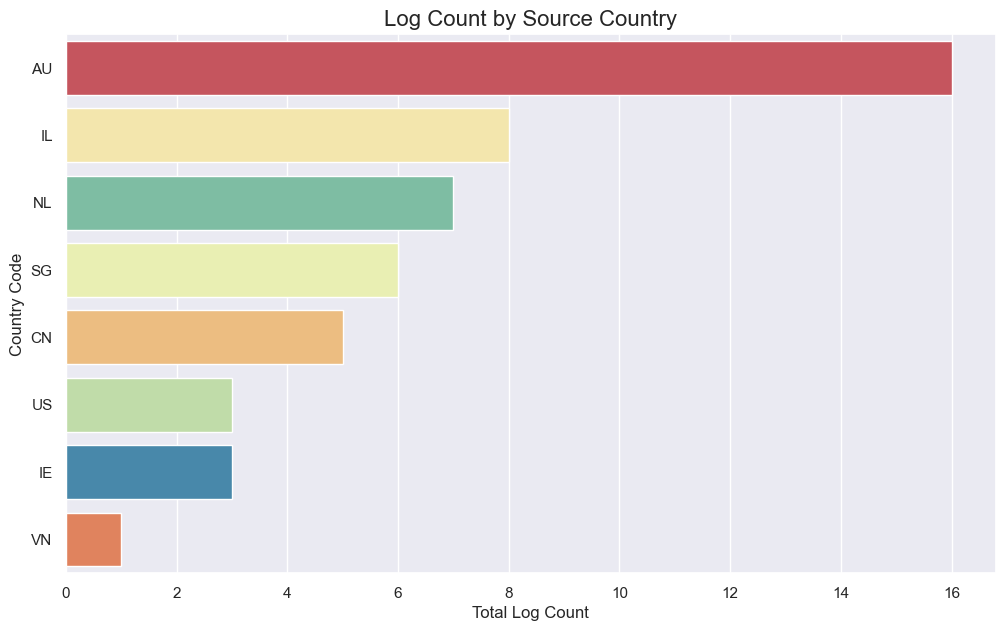

In [35]:
# Create a figure and set its size
plt.figure(figsize=(12, 7))

# Create the countplot for 'country'
# We want to plot only the IPs that *had* a country
# so we .dropna() first.
chart = sns.countplot(
    data=df.dropna(subset=['country']),
    y='country',      # Use 'y' for a horizontal bar chart
    hue='country',    # Explicitly map 'country' to hue (color)
    order=df['country'].value_counts().index,
    palette='Spectral',
    legend=False      # Turn off the legend
)

# Add clear titles and labels
chart.set_title('Log Count by Source Country', fontsize=16)
chart.set_xlabel('Total Log Count', fontsize=12)
chart.set_ylabel('Country Code', fontsize=12)

# Save the figure
plt.savefig('04-log_count_by_country.png')

# Display the chart
plt.show()